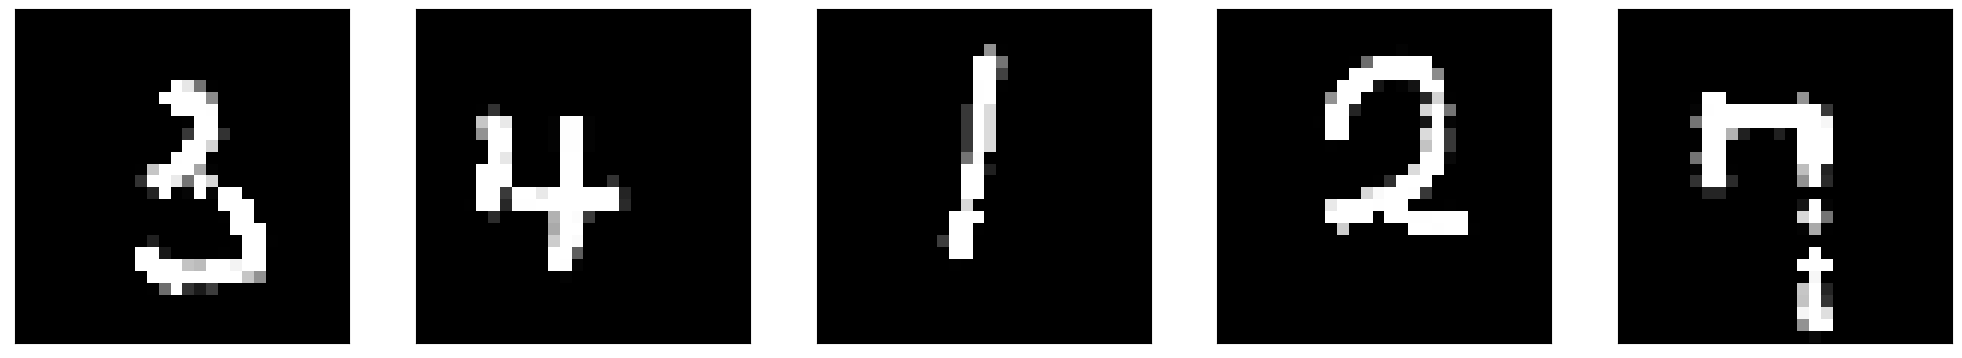

1/1 [==============================] - 0s 34ms/step


In [41]:
import numpy as np
import tensorflow as tf
import cv2 as cv 
import matplotlib.pyplot as plt
import winsound

model=tf.keras.models.load_model('dmlp_trained.h5')

def reset():
    global img, text_size
    
    img=np.ones((200,520,3),dtype=np.uint8)*255
    for i in range(5):
        cv.rectangle(img,(10+i*100,50),(10+(i+1)*100,150),(0,0,255))
    
    # 텍스트를 표시할 위치 계산
    text = 'e:erase s:show r:recognition q:quit'
    text_size, _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.8, 1)
    text_x = (img.shape[1] - text_size[0]) // 2
    text_y = 30
    cv.putText(img, text, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1)

def grab_numerals():
    numerals=[]
    for i in range(5):
        roi=img[51:149,11+i*100:9+(i+1)*100,0]
        roi=255-cv.resize(roi,(28,28),interpolation=cv.INTER_CUBIC)
        numerals.append(roi)  
    numerals=np.array(numerals)
    return numerals

def show():
    numerals=grab_numerals()
    plt.figure(figsize=(25,5))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(numerals[i],cmap='gray')
        plt.xticks([]); plt.yticks([])
    plt.show()
    
def recognition():
    numerals=grab_numerals()
    numerals=numerals.reshape(5,784)
    numerals=numerals.astype(np.float32)/255.0
    res=model.predict(numerals) # 신경망 모델로 예측
    class_ids = np.argmax(res, axis=1)
    
    for i in range(5):
        class_id = class_ids[i]
        confidences = res[i]
        top_2 = confidences.argsort()[-2:][::-1] # 확률 상위 2개 부류
        top_2_str = f"{class_id}({top_2[0]}, {top_2[1]})" # 1순위, 2순위 부류 표시
        
        # 텍스트를 표시할 위치 계산
        text_size, _ = cv.getTextSize(top_2_str, cv.FONT_HERSHEY_SIMPLEX, 1, 1)
        text_x = (i * 100) + (170 - text_size[0]) // 2
        text_y = 180
        
        cv.putText(img, top_2_str, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 1)
    winsound.Beep(1000, 500)

  
        
BrushSiz=4
LColor=(0,0,0)

def writing(event,x,y,flags,param):
    if event==cv.EVENT_LBUTTONDOWN:
        cv.circle(img,(x,y),BrushSiz,LColor,-1) 
    elif event==cv.EVENT_MOUSEMOVE and flags==cv.EVENT_FLAG_LBUTTON: 
        cv.circle(img,(x,y),BrushSiz,LColor,-1)

reset()
cv.namedWindow('Writing')
cv.setMouseCallback('Writing',writing)

while(True):
    cv.imshow('Writing',img)
    key=cv.waitKey(1)
    if key==ord('e'):
        reset()
    elif key==ord('s'):
        show()        
    elif key==ord('r'):
        recognition()
    elif key==ord('q'):
        break
    
cv.destroyAllWindows()